## This notebook make scatterplots 
### based on data from res/[algo]/eval-[data].pkl"

Six scatter plots are made:
1. average f1 change when varying q & algo
2. average f1 change when varying q & data
3. average precision change when varying q & algo
4. average precision change when varying q & data
5. average recall change when varying q & algo
6. average recall change when varying q & data


In [1]:
import os, sys, argparse
import pandas as pd
import numpy as np

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# alg_list = ['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad', 'rev2']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# data_list = ['alpha', 'amazon', 'epinions', 'otc']
data_list = ['otc', 'alpha', 'epinions', 'amazon']
q_range = np.array([0.005, 0.01, 0.03, 0.05, 0.1])
met_list = ['f1', 'prec', 'recl']

k_range = np.arange(10) / 10
n_range = list(range(0, 51, 5))
n_range[0] = 1

In [9]:
from collections import defaultdict

data_list = ['otc','alpha','epinions','amazon']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
markers = ["o", "v", "8", "s", "P", "*", "+"]

def compute_uchange(budget_flag):     #fig, ax, plot_data, title=''
    
    u_change_dict = {}     #u_change_dict[alg_id][met][q] = average_uchange = sum of u_change / # of valid dataset
    
    for alg_id in range(len(alg_list)): 
        u_change_dict[alg_id] = {}     
        for met in met_list:
            u_change_dict[alg_id][met] = {}
            
        for data in data_list:         
            eval_path = '../res/%s/eval-%s.pkl' %(alg_list[alg_id], data)                        
            eval_path2 = '../res/%s/res-%s.pkl' %(alg_list[alg_id], data)
            try:
                with open(eval_path2, 'rb') as fp:
                    pure_results_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/eval-%s.pkl" %(alg_list[alg_id], data))
                continue    
            
            eval_path3 = '../res/%s/budget-res-%s.pkl' %(alg_list[alg_id], data)
            try:
                with open(eval_path3, 'rb') as fp:
                    budget_results_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/budget-res-%s.pkl" %(alg_list[alg_id], data))
                continue   
            
            
            print(alg_list[alg_id], data)
            
            
            q_dict = {}
            for q in range(5):
                heat_dict = {'f1': np.zeros([10, 11]), 'prec': np.zeros([10, 11]), 'recl': np.zeros([10, 11])}
                
                if budget_flag:
                    results_dict = budget_results_dict
                else:
                    results_dict = pure_results_dict
                    
                for k, n in itertools.product(range(10), range(11)):
                    f1_div = 0
                    prec_div = 0
                    recl_div = 0
                        
                    for ind in range(50):
                        if results_dict[(k, n_range[n], ind)] is not None:
                            ytrue = results_dict[(k, n_range[n], ind)]['ytrue']
                 #           print(ytrue)
                            yscore = results_dict[(k, n_range[n], ind)]['yscore']
                            size = len(ytrue)
                            cut = q_range[q] * size
                            ypred = (np.arange(size) < cut) * [1]
      
                            positive = 0
                            negative = 0
                            truepos = 0
                            falsepos = 0
                            trueneg = 0
                            falseneg = 0
                            for id in range(size):
                                if ypred[id] == 1:
                                    positive += 1
                                    if ytrue[id] == 1:
                                        truepos += 1
                                    if ytrue[id] == 0:
                                        falsepos += 1
                                else:
                                    negative += 1
                                    if ytrue[id] == 0:
                                        trueneg += 1
                                    if ytrue[id] == 1: 
                                        falseneg += 1
                            
                            if truepos + falsepos != 0:
                                prec = truepos / positive
                                prec_div += 1
                            else:
                                prec = 0
                            
                            if truepos + falseneg != 0:
                                recl = truepos / (truepos + falseneg)
                                recl_div += 1
                            else:
                                recl = 0
                                
                            if prec + recl != 0:
                                f1 = 2 * prec * recl/(prec + recl)
                                f1_div += 1
                            else:
                                f1 = 0
                            
                            print("truepos " + str(truepos))
                            print("positive " + str(positive))
                            print("size " + str(size))
                            print("prec " + str(prec))
                            print("recl " + str(recl))
                            
                            heat_dict['prec'][k, n] += prec
                            heat_dict['recl'][k, n] += recl
                            heat_dict['f1'][k,n] += f1
                            
                            
                    if f1_div != 0: 
                        heat_dict['f1'][k, n] /= f1_div
                    else:
                        heat_dict['f1'][k, n] = 0
                    
                    if prec_div != 0:
                        heat_dict['prec'][k, n] /= prec_div
                    else:
                        heat_dict['prec'][k, n] = 0
                    
                    if recl_div != 0:
                        heat_dict['recl'][k, n] /= recl_div
                    else:
                        heat_dict['recl'][k, n] = 0
                        
                    
                        
                    
#                     heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
#                     heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
#                     heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
                q_dict[q] = heat_dict   
#                 except (TypeError): #, NameError):
#                     print("HERE !!!!!!")
#                     q_dict[q] = heat_dict
#                     pass
            
            for q in range(5):  
                for met in met_list:
                    try:
                        u_new = q_dict[q][met][1:, :].min()
                        u_old = q_dict[q][met][0, :].mean()

                        u_change = (u_new - u_old) / u_old
                        u_change_dict[alg_id][met][q] = u_change_dict[alg_id][met].get(q, 0) + 1/4 * u_change

                    except KeyError:
                        pass
                     
    return u_change_dict
    


In [10]:
u_change_dict = compute_uchange(False)
u_change_dict 

rev2 otc
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 31
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
si

prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 31
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
pos

prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 42
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 65
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 1
positive 1
size 4
prec 1.0
recl 0.5
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 

size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 30
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 53
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 106
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 29
prec 0.0
recl 0.0
truepos 1
positive 1
size 4
prec 1.0
recl 0.5
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec

size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 40
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 64
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 0
positive 1
size 147
prec 0.0
recl 0.0
truepos 1
positive 1
size 10
prec 1.0
recl 0.125
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 38
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
pre

positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 50
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 75
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 188
prec 0.0
recl 0.0
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 48
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0

positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 60
prec 0.0
recl 0.0
truepos 1
positive 1
size 9
prec 1.0
recl 0.14285714285714285
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 86
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 2
size 229
prec 0.0
recl 0.0
truepos 1
positive 1
size 15
prec 1.0
recl 0.07692307692307693
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 57
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
t

truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 70
prec 0.0
recl 0.0
truepos 1
positive 1
size 11
prec 1.0
recl 0.1111111111111111
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 97
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 0
positive 2
size 271
prec 0.0
recl 0.0
truepos 1
positive 1
size 17
prec 1.0
recl 0.06666666666666667
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 67
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0

truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 80
prec 0.0
recl 0.0
truepos 1
positive 1
size 12
prec 1.0
recl 0.1
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 108
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 21
prec 0.0
recl 0.0
truepos 0
positive 2
size 312
prec 0.0
recl 0.0
truepos 1
positive 1
size 20
prec 1.0
recl 0.05555555555555555
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 0
positive 1
size 77
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
true

recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 80
prec 0.0
recl 0.0
truepos 1
positive 1
size 12
prec 1.0
recl 0.1
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 119
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 0
positive 2
size 353
prec 0.0
recl 0.0
truepos 1
positive 1
size 22
prec 1.0
recl 0.05
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 18
prec 0.0
recl 0.0
truepos 0
positive 1
size 86
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 

recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 90
prec 0.0
recl 0.0
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 119
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 0
positive 2
size 353
prec 0.0
recl 0.0
truepos 1
positive 1
size 22
prec 1.0
recl 0.05
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 18
prec 0.0
recl 0.0
truepos 0
positive 1
size 86
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
r

prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 0
positive 1
size 100
prec 0.0
recl 0.0
truepos 1
positive 1
size 14
prec 1.0
recl 0.08333333333333333
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 130
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 25
prec 0.0
recl 0.0
truepos 0
positive 2
size 394
prec 0.0
recl 0.0
truepos 1
positive 1
size 24
prec 1.0
recl 0.045454545454545456
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 0
positive 1
size 96
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 14
prec 0.0
recl

prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 31
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
pos

size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 42
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 65
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 1
positive 1
size 4
prec 1.0
recl 0.5
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.

positive 1
size 29
prec 0.0
recl 0.0
truepos 1
positive 1
size 4
prec 1.0
recl 0.5
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.25
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 52
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 13
prec 0.0

positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 40
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 64
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 0
positive 2
size 147
prec 0.0
recl 0.0
truepos 1
positive 1
size 10
prec 1.0
recl 0.125
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 38
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1

positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 50
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 75
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 2
size 188
prec 0.0
recl 0.0
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 48
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 8
prec 0

truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 60
prec 0.0
recl 0.0
truepos 1
positive 1
size 9
prec 1.0
recl 0.14285714285714285
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 86
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 3
size 229
prec 0.0
recl 0.0
truepos 1
positive 1
size 15
prec 1.0
recl 0.07692307692307693
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 57
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 9
prec 0.0


truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 70
prec 0.0
recl 0.0
truepos 1
positive 1
size 11
prec 1.0
recl 0.1111111111111111
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 97
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 0
positive 3
size 271
prec 0.0
recl 0.0
truepos 1
positive 1
size 17
prec 1.0
recl 0.06666666666666667
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 67
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 11
prec 0.0

recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 80
prec 0.0
recl 0.0
truepos 1
positive 1
size 12
prec 1.0
recl 0.1
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 2
size 108
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 21
prec 0.0
recl 0.0
truepos 0
positive 4
size 312
prec 0.0
recl 0.0
truepos 1
positive 1
size 20
prec 1.0
recl 0.05555555555555555
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 0
positive 1
size 77
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 12
prec 0.0
recl

recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 80
prec 0.0
recl 0.0
truepos 1
positive 1
size 12
prec 1.0
recl 0.1
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 2
size 119
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 0
positive 4
size 353
prec 0.0
recl 0.0
truepos 1
positive 1
size 22
prec 1.0
recl 0.05
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 18
prec 0.0
recl 0.0
truepos 0
positive 1
size 86
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 

prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 90
prec 0.0
recl 0.0
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 2
size 119
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 0
positive 4
size 353
prec 0.0
recl 0.0
truepos 1
positive 1
size 22
prec 1.0
recl 0.05
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 18
prec 0.0
recl 0.0
truepos 0
positive 1
size 86
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 13
p

prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 0
positive 1
size 100
prec 0.0
recl 0.0
truepos 1
positive 1
size 14
prec 1.0
recl 0.08333333333333333
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 2
size 130
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 25
prec 0.0
recl 0.0
truepos 0
positive 4
size 394
prec 0.0
recl 0.0
truepos 1
positive 1
size 24
prec 1.0
recl 0.045454545454545456
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 0
positive 1
size 96
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666

size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 31
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepo

size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 2
size 42
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 2
size 65
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 1
positive 1
size 4
prec 1.0
recl 0.5
truepos 0
positive 1
size 5
prec 0.

truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 4
size 106
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 29
prec 0.0
recl 0.0
truepos 1
positive 1
size 4
prec 1.0
recl 0.5
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.25
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0


positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 2
size 40
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 2
size 64
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 0
positive 5
size 147
prec 0.0
recl 0.0
truepos 1
positive 1
size 10
prec 1.0
recl 0.125
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 2
size 38
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1

truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 2
size 50
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 3
size 75
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 6
size 188
prec 0.0
recl 0.0
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 2
size 48
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
re

truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 2
size 60
prec 0.0
recl 0.0
truepos 1
positive 1
size 9
prec 1.0
recl 0.14285714285714285
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 3
size 86
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 7
size 229
prec 0.0
recl 0.0
truepos 1
positive 1
size 15
prec 1.0
recl 0.07692307692307693
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 2
size 57
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
r

recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 1
positive 3
size 70
prec 0.3333333333333333
recl 0.01639344262295082
truepos 1
positive 1
size 11
prec 1.0
recl 0.1111111111111111
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 3
size 97
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 0
positive 9
size 271
prec 0.0
recl 0.0
truepos 1
positive 1
size 17
prec 1.0
recl 0.06666666666666667
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 3
size 67
prec 0.0
recl 0.

recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 1
positive 3
size 80
prec 0.3333333333333333
recl 0.014084507042253521
truepos 1
positive 1
size 12
prec 1.0
recl 0.1
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 4
size 108
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 21
prec 0.0
recl 0.0
truepos 1
positive 10
size 312
prec 0.1
recl 0.0034129692832764505
truepos 1
positive 1
size 20
prec 1.0
recl 0.05555555555555555
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 0
positive 3
size 77
prec 0.0


prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 1
positive 3
size 90
prec 0.3333333333333333
recl 0.012345679012345678
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 4
size 119
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 23
prec 0.0
recl 0.0
truepos 1
positive 11
size 353
prec 0.09090909090909091
recl 0.0029940119760479044
truepos 1
positive 1
size 22
prec 1.0
recl 0.05
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 18
prec 0.0
recl 0.0
truepos 0


prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 1
positive 3
size 100
prec 0.3333333333333333
recl 0.01098901098901099
truepos 1
positive 1
size 14
prec 1.0
recl 0.08333333333333333
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 4
size 130
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 25
prec 0.0
recl 0.0
truepos 1
positive 12
size 394
prec 0.08333333333333333
recl 0.0026666666666666666
truepos 1
positive 1
size 24
prec 1.0
recl 0.045454545454545456
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
re

size 11
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 0.0
truepos 1
positive 3
size 100
prec 0.3333333333333333
recl 0.01098901098901099
truepos 1
positive 1
size 14
prec 1.0
recl 0.08333333333333333
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 2
size 31
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 2
size 23
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
t

size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 2
size 31
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 2
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 2
size 23
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 1
positive 1
size 3
prec 1.0
recl 1.0
truepo

positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 20
prec 0.0
recl 0.0
truepos 1
positive 1
size 5
prec 1.0
recl 0.3333333333333333
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 3
size 42
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 4
size 65
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 1
positive 1
siz

positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 2
size 30
prec 0.0
recl 0.0
truepos 1
positive 1
size 6
prec 1.0
recl 0.25
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 3
size 53
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 0
positive 6
size 106
prec 0.0
recl 0.0
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 2
size 29
prec 0.0
recl 0.0
truepos 1
positive 1


truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 3
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 2
size 40
prec 0.0
recl 0.0
truepos 1
positive 1
size 7
prec 1.0
recl 0.2
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 4
size 64
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 13
prec 0.0
recl 0.0
truepos 0
positive 8
size 147
prec 0.0
recl 0.0
truepos 1
positive 1
size 10
prec 1.0
recl 0.125
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 2
size 38
prec 0.0
recl 0.0
truepos 1
positive 1
size

truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 1
positive 3
size 50
prec 0.3333333333333333
recl 0.024390243902439025
truepos 1
positive 1
size 8
prec 1.0
recl 0.16666666666666666
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 4
size 75
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 15
prec 0.0
recl 0.0
truepos 1
positive 10
size 188
prec 0.1
recl 0.005917159763313609
truepos 1
positive 1
size 13
prec 1.0
recl 0.09090909090909091
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0

recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 11
prec 0.0
recl 0.0
truepos 1
positive 3
size 60
prec 0.3333333333333333
recl 0.0196078431372549
truepos 1
positive 1
size 9
prec 1.0
recl 0.14285714285714285
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 5
size 86
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 17
prec 0.0
recl 0.0
truepos 1
positive 12
size 229
prec 0.08333333333333333
recl 0.004761904761904762
truepos 1
positive 1
size 15
prec 1.0
recl 0.07692307692307693
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
pos

recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 4
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 1
positive 4
size 70
prec 0.25
recl 0.01639344262295082
truepos 1
positive 1
size 11
prec 1.0
recl 0.1111111111111111
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 12
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 5
size 97
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 1
size 19
prec 0.0
recl 0.0
truepos 1
positive 14
size 271
prec 0.07142857142857142
recl 0.003968253968253968
truepos 1
positive 1
size 17
prec 1.0
recl 0.06666666666666667
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 

prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 1
positive 4
size 80
prec 0.25
recl 0.014084507042253521
truepos 1
positive 1
size 12
prec 1.0
recl 0.1
truepos 0
positive 1
size 5
prec 0.0
recl 0.0
truepos 0
positive 1
size 14
prec 0.0
recl 0.0
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 7
prec 0.0
recl 0.0
truepos 0
positive 6
size 108
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 1
size 10
prec 0.0
recl 0.0
truepos 0
positive 1
size 6
prec 0.0
recl 0.0
truepos 0
positive 1
size 8
prec 0.0
recl 0.0
truepos 0
positive 2
size 21
prec 0.0
recl 0.0
truepos 2
positive 16
size 312
prec 0.125
recl 0.006825938566552901
truepos 1
positive 1
size 20
prec 1.0
recl 0.05555555555555555
truepos 0
positive 1
size 9
prec 0.0
recl 0.0
truepos 0
positive 1
size 16
prec 0.0
recl 

KeyboardInterrupt: 

rev2 otc
rev2 alpha
no ../res/rev2/eval-epinions.pkl
no ../res/rev2/eval-amazon.pkl
bad otc


/Users/pennyliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in double_scalars


bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon
fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


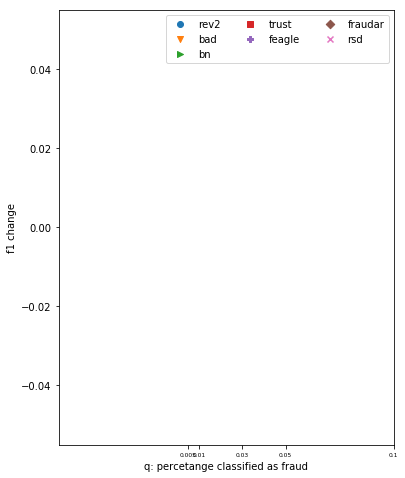

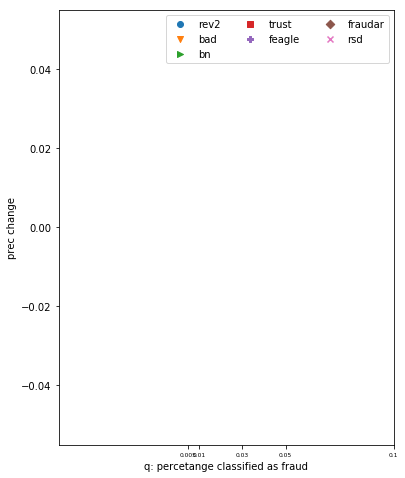

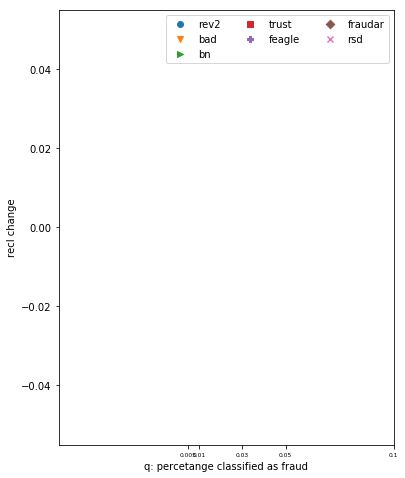

In [5]:
def plot_scatters(budget_flag):
    markers = ["o", "v", ">", "s", "P", "D", "x"]
    u_change_dict = compute_uchange(budget_flag) 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(6,8))     
        ax = fig.add_subplot(111)
        lines = []
        met = met_list[i]
        for alg_id in range(len(alg_list)):
        
            ax.scatter(q_range,  list(u_change_dict[alg_id][met].values()), 
                                       marker= markers[alg_id], label= alg_list[alg_id]) 
#            ax.set_yticks([i * 0.1 - 1 for i in range(20)]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
#            ax.set_yticklabels([i * 0.1 - 1 for i in range(20)]) #-0.6, -0.4,,-1.0, -0.8,, 0.6, 0.8, 1.0])
#            ax.scatter(q_range,  list(u_change_dict[alg_id][met].values()), marker= markers[alg_id], label= alg_list[alg_id])
    
            ax.set_xticks(q_range)
            ax.set_xticklabels(q_range, fontsize= 6)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
        ax.legend(
                loc='upper right',
                ncol=3,
                fontsize=10)
        
        if budget_flag:
            fig.savefig('../res/socket_plot/budget_scatter_total_%s.pdf' %(met_list[i]))
        else:
            fig.savefig('../res/socket_plot/scatter_total_%s.pdf' %(met_list[i]))
        
        

#plot_scatters(True)
plot_scatters(True)
# #plot_scatterplots('bn', 'otc')
# #plot_scatterplots('bn', 'amazon')
# # plot_scatterplots('bn', 'epinions')
# # plot_scatterplots('rsd', 'epinions')
# #plot_scatterplots('fraudar', 'alpha')

rev2 otc
rev2 alpha
no ../res/rev2/budget-res-epinions.pkl
no ../res/rev2/budget-res-amazon.pkl
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon


/Users/pennyliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars


fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


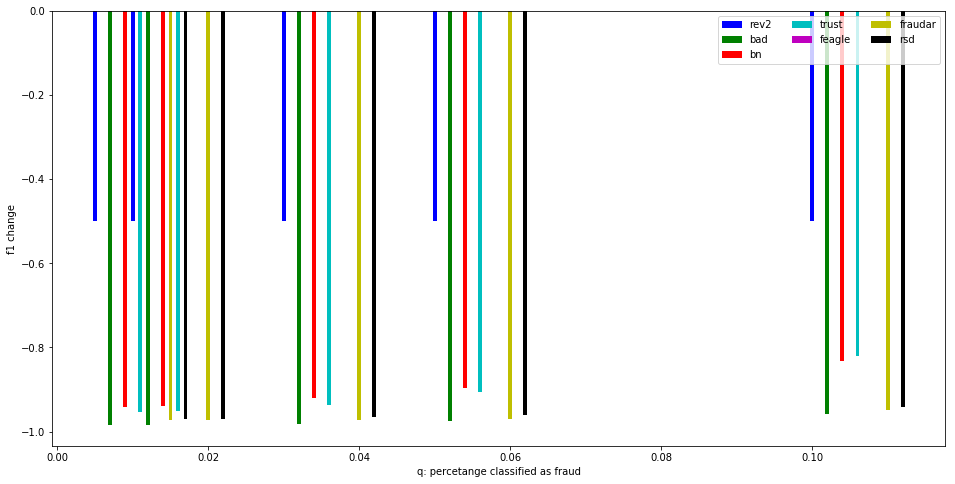

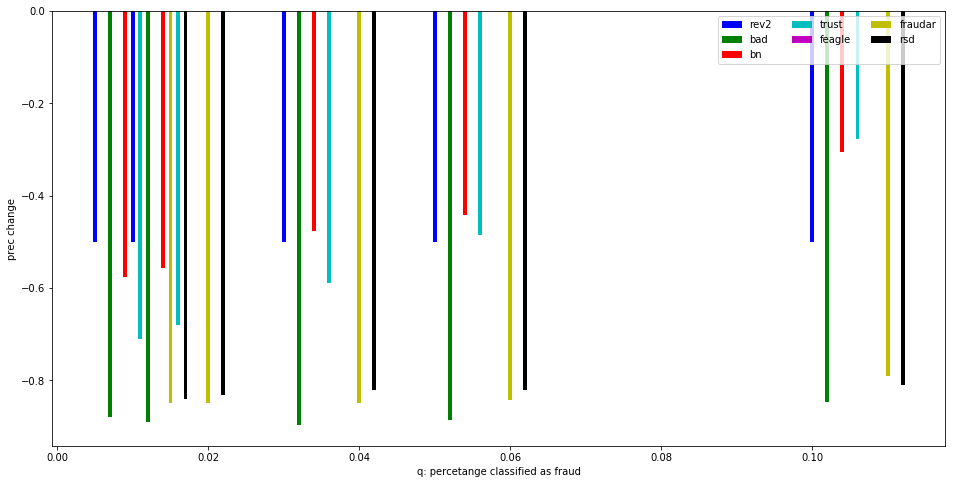

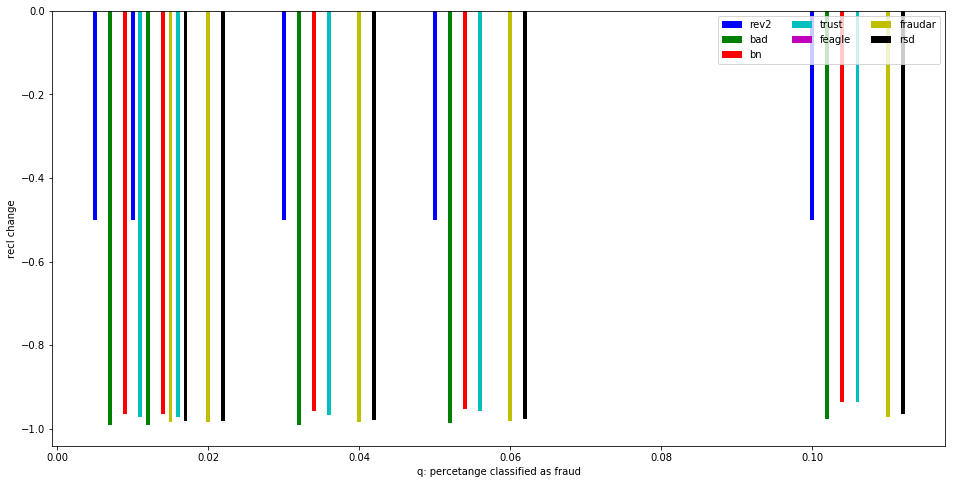

In [78]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
def plot_scatters(budget_flag):
    
    u_change_dict = compute_uchange(True) 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(16, 8))     
        ax = fig.add_subplot(111)
        lines = []
        met = met_list[i]
        for alg_id in range(len(alg_list)):
        
#            ax.scatter(q_range,  list(u_change_dict[alg_id][met].values()), 
                                      # marker= markers[alg_id], label= alg_list[alg_id]) 
#            ax.set_yticks([i * 0.1 - 1 for i in range(20)]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
#            ax.set_yticklabels([i * 0.1 - 1 for i in range(20)]) #-0.6, -0.4,,-1.0, -0.8,, 0.6, 0.8, 1.0])
            ax.bar([q + alg_id * 0.002 for q in q_range],  list(u_change_dict[alg_id][met].values()), 
                   width=0.0005, color = colors[alg_id]) 
                                       # marker= markers[alg_id], label= alg_list[alg_id])
    
#             ax.set_xticks(q_range)
#             ax.set_xticklabels(q_range, fontsize= 6)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
        ax.legend(
            labels = alg_list,
            loc='upper right',
            ncol=3,
            fontsize=10)
        
        if budget_flag:
            fig.savefig('../res/budget_bar_alg_%s.pdf' %(met_list[i]))
        else:
            fig.savefig('../res/bar_alg_%s.pdf' %(met_list[i]))
        
        

plot_scatters(True)

# #plot_scatterplots('bn', 'otc')
# #plot_scatterplots('bn', 'amazon')
# # plot_scatterplots('bn', 'epinions')
# # plot_scatterplots('rsd', 'epinions')
# #plot_scatterplots('fraudar', 'alpha')

In [31]:
# from collections import defaultdict

# data_list = ['otc','alpha','epinions','amazon']
# alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# markers = ["o", "v", "8", "s", "P", "*", "+"]

# def compute_uchange(budget_flag):     #fig, ax, plot_data, title=''
    
#     u_change_dict = {}     #u_change_dict[alg_id][met][q] = average_uchange = sum of u_change / # of valid dataset
    
#     for alg_id in range(len(alg_list)): 
#         u_change_dict[alg_id] = {}     
#         for met in met_list:
#             u_change_dict[alg_id][met] = {}
            
#         for data in data_list:         
#             eval_path = '../res/%s/eval-%s.pkl' %(alg_list[alg_id], data)                            
#             try:
#                 with open(eval_path, 'rb') as fp:
#                     metrics_dict = pickle.load(fp)
#             except FileNotFoundError:
#                 print("no ../res/%s/eval-%s.pkl" %(alg_list[alg_id], data))
#                 continue
       
#             eval_path2 = '../res/%s/res-%s.pkl' %(alg_list[alg_id], data)
#             try:
#                 with open(eval_path2, 'rb') as fp:
#                     results_dict = pickle.load(fp)
#             except FileNotFoundError:
#                 print("no ../res/%s/eval-%s.pkl" %(alg_list[alg_id], data))
#                 continue    
    
#             print(alg_list[alg_id], data)
            
            
#             q_dict = {}
#             for q in range(5):
#                 heat_dict = {'f1': np.zeros([10, 11]), 'prec': np.zeros([10, 11]), 'recl': np.zeros([10, 11])}
                
#                 for k, n in itertools.product(range(10), range(11)):
#                     for ind in range(50):
#                         if results_dict[(k, n_range[n], ind)] is not None:
#                             ytrue = results_dict[(k, n_range[n], ind)]['ytrue']
#                             yscore = results_dict[(k, n_range[n], ind)]['yscore']
#                             size = len(ytrue)
#                             cut = q_range[q] * size
#                             ypred = (np.arange(size) < cut) * [1]
                        
#                             positive = 0
#                             negative = 0
#                             truepos = 0
#                             falsepos = 0
#                             trueneg = 0
#                             falseneg = 0
#                             for id in range(size):
#                                 if ypred[id] == 1:
#                                     positive += 1
#                                     if ytrue[id] == 1:
#                                         truepos += 1
#                                     if ytrue[id] == 0:
#                                         falsepos += 1
#                                 else:
#                                     negative += 1
#                                     if ytrue[id] == 0:
#                                         trueneg += 1
#                                     if ytrue[id] == 1: 
#                                         falseneg += 1
                            
# #                             print(positive)
# #                             print(size)
# #                             print(ytrue)
                            
#                             prec = truepos / (truepos + falsepos)
#                             recl = truepos / (truepos + falseneg)
#                             if prec + recl != 0:
#                                 f1 = 2 * prec * recl/(prec + recl)
#                             else:
#                                 f1 = 0
#                             heat_dict['prec'][k, n] += prec
#                             heat_dict['recl'][k, n] += recl
#                             heat_dict['f1'][k,n] += f1
                            
                
#                         ##if metrics_dict[(k, n_range[n], ind)] is not None:
#                            ## heat_dict['f1'][k, n] += metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]]
#                            ## heat_dict['prec'][k, n] += metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]]
#                            ## heat_dict['recl'][k, n]  += metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] 

#                     heat_dict['f1'][k, n] /= 50
#                     heat_dict['prec'][k, n] /= 50
#                     heat_dict['recl'][k, n] /= 50
                    
# #                     heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
# #                     heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
# #                     heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
#                 q_dict[q] = heat_dict   
# #                 except (TypeError): #, NameError):
# #                     print("HERE !!!!!!")
# #                     q_dict[q] = heat_dict
# #                     pass
            
#             for q in range(5):  
#                 for met in met_list:
#                     try:
#                         # div = 0
#                         u_new = q_dict[q][met][1:, :].min()
#                         u_old = q_dict[q][met][0, :].mean()

#                         u_change = (u_new - u_old) / u_old
#                       #  print(u_change)
#                         u_change_dict[alg_id][met][q] = u_change_dict[alg_id][met].get(q, 0) + 1/4 * u_change
#                         # div += 1
               
#                     except KeyError:
#                         pass
                     
#     return u_change_dict
    
# u_change_dict = compute_uchange(True)


rev2 otc
rev2 alpha
no ../res/rev2/eval-epinions.pkl
no ../res/rev2/eval-amazon.pkl
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon


/Users/pennyliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars


fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


In [5]:
# parser = argparse.ArgumentParser(description='heatmap creator')
# parser.add_argument('-o', '--output', type=str, default='-', action='store', help='target')
# parser.add_argument('-d', '--data', type=str, default='alpha', choices=['alpha', 'amazon', 'epinions', 'otc'], help='data name')
# parser.add_argument('-a', '--alg', type=str, default='bad', choices=['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad'], help='alg name')

# if bool(getattr(sys, 'ps1', sys.flags.interactive)):
#     from tqdm import tqdm_notebook as tqdm
#     print('interactive mode')
#     parsed = parser.parse_args(['--data', 'alpha', '--alg', 'bn'])
# else:
#     from tqdm import tqdm
#     print('script mode')
#     parsed = parser.parse_args(sys.argv[1:])
#     display=print

# print(parsed)

In [27]:
# # Budget model scatterplots

# from collections import defaultdict

# data_list = ['otc','alpha','epinions','amazon']
# alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# markers = ["o", "v", "8", "s", "P", "*", "+"]

# def compute_uchange():     #fig, ax, plot_data, title=''
    
#     u_change_dict = {}     #u_change_dict[alg_id][met][q] = average_uchange = sum of u_change / # of valid dataset
    
#     for alg_id in range(len(alg_list)): 
#         u_change_dict[alg_id] = {}     
#         for met in met_list:
#             u_change_dict[alg_id][met] = {}
            
#         for data in data_list:         
#             eval_path = '../res/%s/budget-eval-%s.pkl' %(alg_list[alg_id], data)                            
#             try:
#                 with open(eval_path, 'rb') as fp:
#                     metrics_dict = pickle.load(fp)
#             except FileNotFoundError:
#                 print("no ../res/%s/budget-eval-%s.pkl" %(alg_list[alg_id], data))
#                 continue
# #            except ModuleNotFoundError:
# #                continue
            
#             print(alg_list[alg_id], data)
            
            
#             q_dict = {}
#             for q in range(5):
#                 heat_dict = {'f1': np.zeros([10, 11]), 'prec': np.zeros([10, 11]), 'recl': np.zeros([10, 11])}
                
# #                 try:
#                 for k, n in itertools.product(range(10), range(11)):
#                     for ind in range(50):
#                         if metrics_dict[(k, n_range[n], ind)] is not None:
#                             heat_dict['f1'][k, n] += metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]]
#                             heat_dict['prec'][k, n] += metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]]
#                             heat_dict['recl'][k, n]  += metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] 

#                     heat_dict['f1'][k, n] /= 50
#                     heat_dict['prec'][k, n] /= 50
#                     heat_dict['recl'][k, n] /= 50
                    
# #                     heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
# #                     heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
# #                     heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
#                 q_dict[q] = heat_dict   
# #                 except (TypeError): #, NameError):
# #                     print("HERE !!!!!!")
# #                     q_dict[q] = heat_dict
# #                     pass
            
#             for q in range(5):  
#                 for met in met_list:
#                     try:
#                         # div = 0
#                         u_new = q_dict[q][met][1:, :].min()
#                         u_old = q_dict[q][met][0, :].mean()

# #                        k_new, n_new = np.unravel_index(q_dict[q][met][1:, :].argmin(), q_dict[q][met][1:, :].shape)                
# #                        k_new += 1

#                         u_change = (u_new - u_old) / u_old
#                         print(u_change)
#                         u_change_dict[alg_id][met][q] = u_change_dict[alg_id][met].get(q, 0) + 1/4 * u_change
#                         # div += 1
               
#                     except KeyError:
#                         # div -= 1
#                         pass
                    
# #                     try:
# #                         u_change_dict[alg_id][met][q] /= 4
# #                     except KeyError:
# #                         pass
                        
                     
#     return u_change_dict
    
# u_change_dict = compute_uchange()






TypeError: scalar() argument 1 must be numpy.dtype, not numpy.dtype

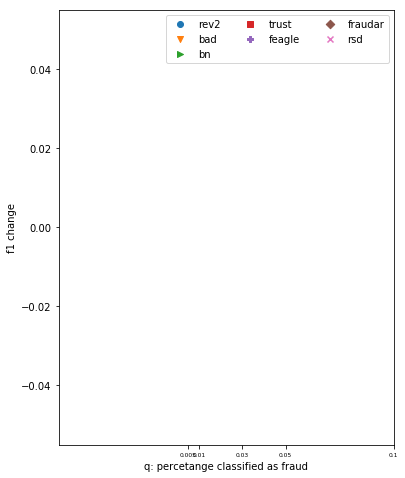

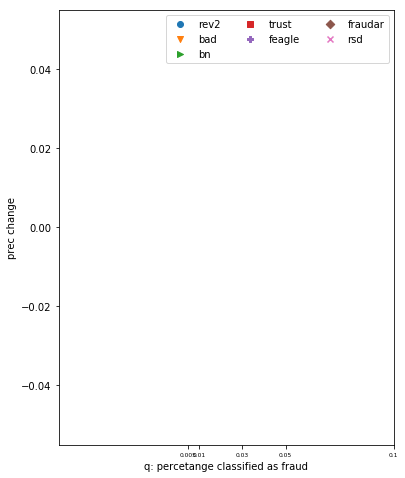

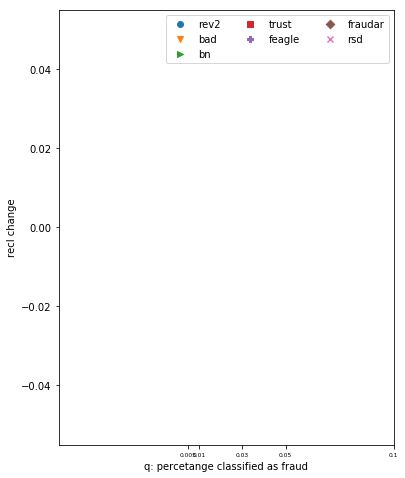

In [37]:
# Budget model scatterplots
markers = ["o", "v", ">", "s", "P", "D", "x"]
def plot_scatters():
    
#    u_change_dict = compute_uchange() 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(6,8))     
        ax = fig.add_subplot(111)
        lines = []
        met = met_list[i]
        for alg_id in range(len(alg_list)):
        
            ax.scatter(q_range,  list(u_change_dict[alg_id][met].values()), marker= markers[alg_id], label= alg_list[alg_id]) 
#            ax.set_yticks([i * 0.1 - 1 for i in range(20)]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
#            ax.set_yticklabels([i * 0.1 - 1 for i in range(20)]) #-0.6, -0.4,,-1.0, -0.8,, 0.6, 0.8, 1.0])

            ax.set_xticks(q_range)
            ax.set_xticklabels(q_range, fontsize= 6)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
        ax.legend(
                loc='upper right',
                ncol=3,
                fontsize=10)
        
        fig.savefig('../res/budget-scatter_alg_%s.pdf' %(met_list[i]))
        
        

plot_scatters()

# #plot_scatterplots('bn', 'otc')
# #plot_scatterplots('bn', 'amazon')
# # plot_scatterplots('bn', 'epinions')
# # plot_scatterplots('rsd', 'epinions')
# #plot_scatterplots('fraudar', 'alpha')




In [19]:
eval_path = '../res/%s/eval-%s.pkl' %('bn', 'epinions')
with open(eval_path, 'rb') as fp:
    metrics_dict = pickle.load(fp)
metrics_dict


{(0,
  1,
  0): {'prec': {0.005: 0.0,
   0.01: 0.0,
   0.03: 0.3333333333333333,
   0.05: 0.2,
   0.1: 0.1111111111111111}, 'recl': {0.005: 0.0,
   0.01: 0.0,
   0.03: 1.0,
   0.05: 1.0,
   0.1: 1.0}, 'f1': {0.005: 0.0,
   0.01: 0.0,
   0.03: 0.5,
   0.05: 0.33333333333333337,
   0.1: 0.19999999999999998}},
 (0, 1, 1): {'prec': {0.005: 1.0, 0.01: 1.0, 0.03: 0.5, 0.05: 0.5, 0.1: 0.25},
  'recl': {0.005: 1.0, 0.01: 1.0, 0.03: 1.0, 0.05: 1.0, 0.1: 1.0},
  'f1': {0.005: 1.0,
   0.01: 1.0,
   0.03: 0.6666666666666666,
   0.05: 0.6666666666666666,
   0.1: 0.4}},
 (0,
  1,
  2): {'prec': {0.005: 0.0,
   0.01: 0.0,
   0.03: 0.16666666666666666,
   0.05: 0.1,
   0.1: 0.05263157894736842}, 'recl': {0.005: 0.0,
   0.01: 0.0,
   0.03: 1.0,
   0.05: 1.0,
   0.1: 1.0}, 'f1': {0.005: 0.0,
   0.01: 0.0,
   0.03: 0.2857142857142857,
   0.05: 0.18181818181818182,
   0.1: 0.1}},
 (0,
  1,
  3): {'prec': {0.005: 1.0,
   0.01: 0.5,
   0.03: 0.25,
   0.05: 0.16666666666666666,
   0.1: 0.09090909090909091}, 

In [20]:
from collections import defaultdict

data_list = ['otc','alpha','epinions','amazon']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']

def compute_uchange():     #fig, ax, plot_data, title=''
    
    u_change_dict = {}     #u_change_dict[data_id][met][q] = average_uchange = sum of u_change / # of valid_alg (7)
    
    for data_id in range(len(data_list)): 
        u_change_dict[data_id] = {}     
        for met in met_list:
            u_change_dict[data_id][met] = {}
            
        for alg in ['feagle']: #alg_list:         
            eval_path = '../res/%s/eval-%s.pkl' %(alg, data_list[data_id])                            
            try:
                with open(eval_path, 'rb') as fp:
                    metrics_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/eval-%s.pkl" %(alg, data_list[data_id]))
                continue
            
            print(alg, data_list[data_id])
            
            q_dict = {}
            for q in range(5):
                heat_dict = {'f1': np.zeros([10, 11]), 'prec': np.zeros([10, 11]), 'recl': np.zeros([10, 11])}
                
                for k, n in itertools.product(range(10), range(11)):
                    for ind in range(50):
                        if metrics_dict[(k, n_range[n], ind)] is not None:
                            heat_dict['f1'][k, n] += metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]]
                            heat_dict['prec'][k, n] += metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]]
                            heat_dict['recl'][k, n]  += metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] 
                            
                    heat_dict['f1'][k, n] /= 50
                    heat_dict['prec'][k, n] /= 50
                    heat_dict['recl'][k, n] /= 50
                    
                q_dict[q] = heat_dict
            
            for q in range(5):  
                for met in met_list:
                    #try:

                    u_new = q_dict[q][met][1:, :].min()
                    u_old = q_dict[q][met][0, :].mean()
                    print(u_new, u_old)

#                        k_new, n_new = np.unravel_index(q_dict[q][met][1:, :].argmin(), q_dict[q][met][1:, :].shape)                
#                        k_new += 1
                    if u_old is not 0:
                        u_change = (u_new - u_old) / u_old
                    else:
                        u_change = 0

                    u_change_dict[data_id][met][q] = u_change_dict[data_id][met].get(q, 0) + 1/7 * u_change
                   
                            
    return u_change_dict
    

u_change_dict = compute_uchange()
# print(u_change_dict[0])
# print(u_change_dict[1])
print(u_change_dict[2])
# print(u_change_dict[3])

feagle otc
0.15635115187348006 0.4243809523809523
0.78 0.5199999999999999
0.091492722126792 0.39388888888888884
0.1563474314185638 0.4243809523809523
0.775 0.5199999999999999
0.091492722126792 0.39388888888888884
0.16185230945468 0.4243809523809523
0.768 0.5199999999999999
0.09441525791844371 0.39388888888888884
0.17709508904640248 0.42971428571428566
0.7575 0.5199999999999999
0.10297861442352488 0.3988888888888889
0.242440019893972 0.4398124098124098
0.7647142857142858 0.5183333333333334
0.1433318012179529 0.40844444444444433
feagle alpha
0.12318635737864807 0.3314285714285714
0.62 0.46
0.07131456997460793 0.2873333333333333
0.12318635737864807 0.3314285714285714
0.62 0.46
0.07131456997460793 0.2873333333333333
0.12613972472689366 0.3314285714285714
0.63 0.46
0.07293115068731489 0.2873333333333333
0.14566197836278974 0.3314285714285714
0.62 0.46
0.08402840421506032 0.2873333333333333
0.2012417544062193 0.35433333333333333
0.63 0.4699999999999999
0.11856707105687171 0.30900000000000005

/Users/pennyliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


feagle otc
0.15635115187348006 0.4243809523809523
0.78 0.5199999999999999
0.091492722126792 0.39388888888888884
0.1563474314185638 0.4243809523809523
0.775 0.5199999999999999
0.091492722126792 0.39388888888888884
0.16185230945468 0.4243809523809523
0.768 0.5199999999999999
0.09441525791844371 0.39388888888888884
0.17709508904640248 0.42971428571428566
0.7575 0.5199999999999999
0.10297861442352488 0.3988888888888889
0.242440019893972 0.4398124098124098
0.7647142857142858 0.5183333333333334
0.1433318012179529 0.40844444444444433
feagle alpha
0.12318635737864807 0.3314285714285714
0.62 0.46
0.07131456997460793 0.2873333333333333
0.12318635737864807 0.3314285714285714
0.62 0.46
0.07131456997460793 0.2873333333333333
0.12613972472689366 0.3314285714285714
0.63 0.46
0.07293115068731489 0.2873333333333333
0.14566197836278974 0.3314285714285714
0.62 0.46
0.08402840421506032 0.2873333333333333
0.2012417544062193 0.35433333333333333
0.63 0.4699999999999999
0.11856707105687171 0.30900000000000005

/Users/pennyliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


0.02456511311594251 0.48183838383838373
0.43 0.5618181818181818
0.012827363593131998 0.45313131313131316
0.027647125055735598 0.48183838383838373
0.4466666666666667 0.5618181818181818
0.014406328270365915 0.45313131313131316
0.04980435758326574 0.4897245179063361
0.48066666666666663 0.5678787878787878
0.02610618948042292 0.46267676767676763
0.07200685508435263 0.5111184573002755
0.49657142857142844 0.5825757575757575
0.038753982206998036 0.48721212121212115
0.15157998460315852 0.564883116883117
0.5780815295815295 0.5837748917748918
0.08615490459730742 0.5918989898989898


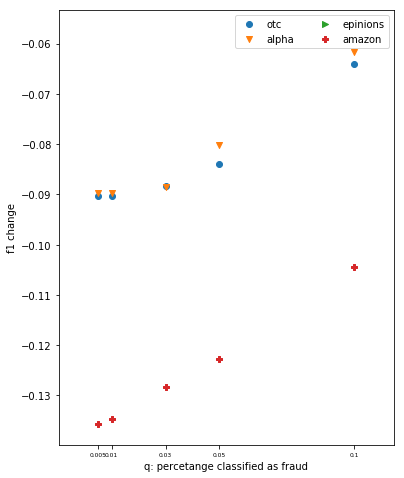

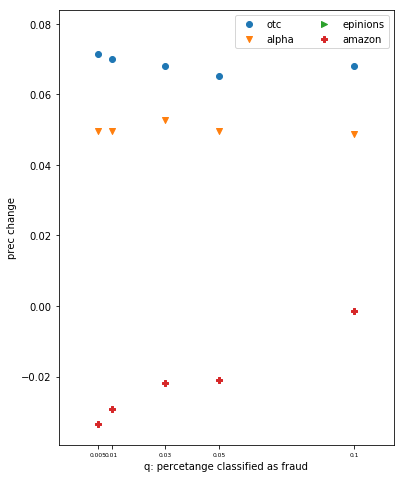

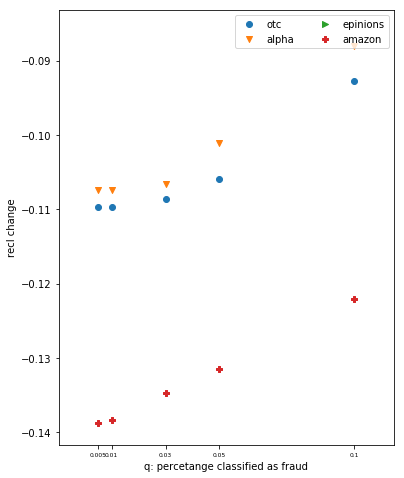

In [21]:
markers = ["o", "v", ">", "P"]   #markers for 4 datasets , "s", "D", "x"]
def plot_scatters():
    
    u_change_dict = compute_uchange() 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(6,8))     
        ax = fig.add_subplot(111)
        met = met_list[i]
        
        for data_id in range(len(data_list)):
            u_change_list = list(u_change_dict[data_id][met].values())
#            print(u_change_list)
            if(len(u_change_list) != 5):
                print("%s not 5 values" %data_list[data_id])
                continue
            
            
            ax.scatter(q_range,  u_change_list, 
                                       marker= markers[data_id], label= data_list[data_id]) 
#             ax.set_yticks([round(i * 0.1 - 1, 2) for i in range(20)]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
#             ax.set_yticklabels([round(i * 0.1 - 1, 2) for i in range(20)])

            ax.set_xticks(q_range)
            ax.set_xticklabels(q_range, fontsize=6)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
        ax.legend(
                loc='upper right',
                ncol=2,
                fontsize=10)
        
        fig.savefig('../res/scatter_data_%s.pdf' %(met_list[i]))
        

plot_scatters()

In [13]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

for alg in alg_list:
        for met in met_list:
            for q in range(5):
                print(alg, met, q_range[q], u_change_dict[alg][met][q])
        
                        ##if metrics_dict[(k, n_range[n], ind)] is not None:
                           ## heat_dict['f1'][k, n] += metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]]
                           ## heat_dict['prec'][k, n] += metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]]
                           ## heat_dict['recl'][k, n]  += metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] 

KeyError: 'rev2'